# How to use Pydantic model as state

Every [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph) is a state machine. When initializing, it accepts a `state_schema` that tells it the "shape" of its state and how to incorporate updates from the nodes into a shared representation of what work has been done.

The `state_schema` can be any [type](https://docs.python.org/3/library/stdtypes.html#type-objects), though we typically use a python-native `TypedDict` in our examples (or in the case of [MessageGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#messagegraph), a [list](https://docs.python.org/3/library/stdtypes.html#list)).

If you want to apply additional validation on state updates, you could instead opt for a pydantic [BaseModel](https://docs.pydantic.dev/latest/api/base_model/).

In this example, we will create a ReAct agent using a pydantic base model as the state object. This means all nodes receive an instance of the model as their first arg, and validation is run before each node executes.

## Setup

First we need to install the packages required

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use create a placeholder search engine.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/v0.2/docs/how_to/custom_tools) on how to do that.


In [2]:
from langchain_core.tools import tool


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return "The answer to your question lies within."


tools = [search]

We can now wrap these tools in a simple [tool-calling node](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode).

In [3]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [5]:
model = model.bind_tools(tools)

## Define the agent state

The main type of graph in `langgraph` is the [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph).
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `pydantic.BaseModel` with one key (`messages`) and annotate it so that the `messages` attribute is treated as "append-only".


<div class="admonition note">
    <p class="admonition-title">Using Pydantic with LangChain</p>
    <p>
        This notebook uses Pydantic v2 <code>BaseModel</code>, which requires <code>langchain-core >= 0.3</code>. Using <code>langchain-core < 0.3</code> will result in errors due to mixing of Pydantic v1 and v2 <code>BaseModels</code>.
    </p>
</div>  

In [6]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage

from pydantic import BaseModel

class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

**MODIFICATION**

We define each node to receive the AgentState base model as its first argument.

In [7]:
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state.messages
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state.messages
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

## Define the graph

We can now put it all together and define the graph!

In [8]:
from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

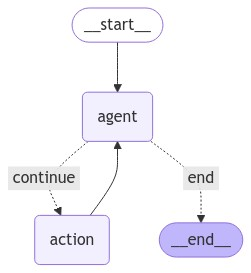

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) as all other LangChain runnables.

In [10]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  search (call_eJMUn9rNv4abSfYe9kVmzk8E)
 Call ID: call_eJMUn9rNv4abSfYe9kVmzk8E
  Args:
    query: weather in San Francisco
================================= Tool Message =================================
Name: search

The answer to your question lies within.
================================== Ai Message ==================================

I have initiated a search for the weather in San Francisco. I will provide you with the information as soon as I receive the results.
